# 1
Goal: show how many of the good particles in your cryoEM map come from which hole/square

Input: your cryoEM map with info => file names should contain info re: hole/ grid square => you can then add all this data together, count things, make histograms, heat maps...

Dream: Ideally, in the end, you'd be able to have a heatmap image to view along with a rough image of the grid => can easily see what "good" ice thickness etc look in this particular case

# 2
File name format:

Micrographs/20190117_0713_Fractions.mrc
=> ie "an image" is defined by the date & time when the movie was collected

# 3
The file in the Refine3D directory that has this data is called "run_data.star"

Items in the file are tab-separated lines - one line for one particle

The entry within a line that describes the micrograph where the particle is from is #7

Eg MotionCorr/job007/Micrographs/20190116_1350_Fractions.mrc

# 4
Ha, we only have the date & time in the filename for each image, because we did "rename_truncate" when making links to our original data.

Original file format is:

Eg FoilHole_15745455_Data_15747751_15747752_20190117_0746_Fractions.mrc

So there you go, we'll need to map the date and time file name back to the full name => and then extract the relevant hole number.

Once we have the original hole numbering, we can then hopefully link stuff back to some atlas image of the grid (eg we took some as part of grid screening on Talos. Do people take an atlas image before beginning data collection as well?).

For now, though, our goal shall be to build a table where, for each hole name, you see how many particles went into your cryoEM map.

# 5
Actual put-together code to populate a pandas dataframe

# 6 Plans
## Plans for the script

++ create a pandas dataframe to store grid square no, no of micrographs, no of particles, avg no of particles per micrograph for each grid

-- tidy the code up to make sense, be clear, not have random extra test examples in the middle

-- make output neat, informative, nice (user friendly)

-- make input user friendly

-- make things less "heuristic"

++++ eg use sensible logic for parsing text (so that it has a chance of working on other people's data, too, and not just mine)
++++ eg avoid random empirical parameters (eg "34 and -1" in readlines - just do it properly and write code to determine what those numbers should be)

## Plans for making graphs
++ sit down & peacefully find nice matplotlib.pyplot tutorials, so you have a solid idea of the principles

-- not much plotting is required, really

(---- eg number of particles vs micrograph name [sort of particles per hole thing])

++++ eg average number of particles per micrograph vs grid square number
## Plans for mapping grid square number to the atlas image
++ Talk to Dima / Steve:
Eg where are the files that hold instructions for the microscope for data collection / what could be the file that records which squares you chose and labelled in the atlas screening stage

++++ Solution: the squares you pick are then excecuted in that order. ie data from square 1 will have earliest time stamp, then data from square 2 etc. Woohoo!
## Other bits
-- Could also calculate the same set of information for particles from other data sets: eg from autopicking, from good 2D classes etc. And compare the two! Here graphs could be very useful.


## Far away future
-- Tom: also show which holes have highest number of good particles (same thing as with squares, just for holes)

---- Im: a beautiful heatmap of an image of a square with holes in it would be lovely

-- Karol says I could have a machine learning algorithm to then look at the whole atlas and point out grids that are likely to be good :) Seems relatively very simple, though also probably not particularly useful. Still, a great project to do (!)

---- Update: actually, maybe this sounds not necessarily very simple, but possibly quite useful. Ha

-- For crazy fun, could add a GUI :)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# open file
inputfile= open("autopick_particles.star")

# read the whole file into lines
# splitlines removes the separator at the end of each line
file_content = inputfile.read().splitlines()

# inspect beginning and end of the list of lines => see what may need to be done to clean them up
print(len(file_content))

print(file_content[0:5])
print(file_content[-5:])

168020
['# RELION; version 3.0-beta-2', '', 'data_', '', 'loop_ ']
[' 1165.660079  3299.667984            6     0.787474   170.000000 000112@Extract/job023/Micrographs/20190116_1350_Fractions.mrcs MotionCorr/job007/Micrographs/20190116_1350_Fractions.mrc 10000.000000     1.430000     3.622000     0.089537   200.000000 26499.250000 26981.240234    89.139999     2.700000     0.000000     1.000000     0.000000     0.100000 ', ' 1601.770751  3935.114625            6     0.813114   205.000000 000113@Extract/job023/Micrographs/20190116_1350_Fractions.mrcs MotionCorr/job007/Micrographs/20190116_1350_Fractions.mrc 10000.000000     1.430000     3.622000     0.089537   200.000000 26499.250000 26981.240234    89.139999     2.700000     0.000000     1.000000     0.000000     0.100000 ', ' 1143.399209  3946.245059            6     0.822739   250.000000 000114@Extract/job023/Micrographs/20190116_1350_Fractions.mrcs MotionCorr/job007/Micrographs/20190116_1350_Fractions.mrc 10000.000000     1.430000  

In [3]:
# want to get to the part of the file that contains particle info (rather than headers, empty lines etc)

# find how much of the header needs to be lost: skip every line that contains a "#" - which seems to only exist in the header
i = -1
for line in file_content:
    i = i+1
    if '#' in line:
        start = i + 1
print(start)

# remove the last line, since it's only blank space
star_lines = file_content[start:-1]


# inpect the trimmed list of lines
print(len(star_lines))

print(star_lines[0:5])
print(star_lines[-5:])

25
167994
['  841.865613   123.446640            3     0.989427   345.000000 000001@Extract/job023/Micrographs/20190117_0759_Fractions.mrcs MotionCorr/job007/Micrographs/20190117_0759_Fractions.mrc 10000.000000     1.430000     3.202000     0.094861   200.000000 20248.830078 20676.970703    87.139999     2.700000     0.000000     1.000000     0.000000     0.100000 ', ' 3587.035573   123.446640            6     1.915608    75.000000 000002@Extract/job023/Micrographs/20190117_0759_Fractions.mrcs MotionCorr/job007/Micrographs/20190117_0759_Fractions.mrc 10000.000000     1.430000     3.202000     0.094861   200.000000 20248.830078 20676.970703    87.139999     2.700000     0.000000     1.000000     0.000000     0.100000 ', ' 2201.802372   157.849802            1     0.740655   185.000000 000003@Extract/job023/Micrographs/20190117_0759_Fractions.mrcs MotionCorr/job007/Micrographs/20190117_0759_Fractions.mrc 10000.000000     1.430000     3.202000     0.094861   200.000000 20248.830078 20676.

In [4]:
# set up a pandas dataframe to handle micrograph data
particles = pd.DataFrame(columns = ['micrograph', 'count'])
particles.head()

# set up a pandas dataframe to handle coordinate data for each particle
coordinates = pd.DataFrame(columns = ['x_coordinate', 'y_coordinate', 'x_origin', 'y_origin'])
coordinates.head()

,x_coordinate,y_coordinate,x_origin,y_origin


In [8]:
for line in star_lines:
    
    # split string - and again - etc
    step_0 = line.split()

    # get particle coordinate data from the star file line
    x_coor = step_0[0]
    y_coor = step_0[1]
    #x_ori = step_0[23]
    x_ori = "not applicable"
    #y_ori = step_0[24]
    y_ori = "not applicable"

    #print(x_coor, y_coor, x_ori, y_ori)
    
    # add coordinate data to a pandas dataframe
    coordinates = coordinates.append({'x_coordinate':x_coor, 'y_coordinate':y_coor, 'x_origin':x_ori, 'y_origin':y_ori}, ignore_index=True)
    #print(coordinates.head(5))

    
    
    
    
    
    # get micrograph name from the star file line
    step_1 = step_0[6]
    step_2 = step_1.split('Micrographs')
    step_3 = step_2[1]
    step_4 = step_3.split("/")
    step_5 = step_4[1]
    step_6 = step_5.split('_Fractions.mrc')
    step_7 = step_6[0]

    current_particle = step_7
    #print(current_particle)

    # if the micrograph is already in the pandas dataframe => up the count by one
    if current_particle in particles['micrograph'].tolist():
            particles.loc[particles['micrograph'] == current_particle, 'count'] += 1
    # if the micrograph isn't yet in the dataframe => add with count set to one
    else:
        particles = particles.append({'micrograph': current_particle, 'count': 1}, ignore_index=True)
    
    #print(particles.head(5))

In [9]:
coordinates.head(5)
coordinates.tail(5)

,x_coordinate,y_coordinate,x_origin,y_origin
335983,1086.735178,3261.217391,not applicable,not applicable
335984,1165.660079,3299.667984,not applicable,not applicable
335985,1601.770751,3935.114625,not applicable,not applicable
335986,1143.399209,3946.245059,not applicable,not applicable
335987,158.861660,1519.810277,not applicable,not applicable


In [10]:
particles.head(5)
particles.tail(5)

,micrograph,count
681,20190116_1355,388
682,20190116_1354,218
683,20190116_1352,318
684,20190116_1351,228
685,20190116_1350,230


In [11]:
print("Number of micrographs with particles: ", particles.shape[0])
print("Total number of particles: ", particles['count'].sum())

Number of micrographs with particles:  686
Total number of particles:  335988


# 7
Want to establish connection between date & time of a micrograph with its grid quare number.
Use a file that shows how these things are connected.
Extract useful info into pandas dataframe.
(Loop to parse data from micrograph names into separate pandas columns)

In [12]:
linkfile= open("linknames.txt")
linknames = pd.read_csv('linknames.txt', sep=" ", header=None)
print(linknames.head())

full_links = linknames.iloc[:,10:11]
print(full_links.head(5))

# rename column

print(list(full_links.columns.values))
full_links.rename(columns={10: 'path'}, inplace=True)
print(full_links.head(5))

count_rows_full_links = full_links.shape[0]
print("Number of rows is ", count_rows_full_links)

# add empty columns
full_links['grid_square_no'] = np.nan
full_links['micrograph'] = np.nan
full_links.head(5)

           0   1      2                   3   4    5   6      7   \
0  lrwxrwxrwx   1  kb449  rds-bfl20-luisilab  93  Jan  18  11:02   
1  lrwxrwxrwx   1  kb449  rds-bfl20-luisilab  93  Jan  18  11:02   
2  lrwxrwxrwx   1  kb449  rds-bfl20-luisilab  93  Jan  18  11:02   
3  lrwxrwxrwx   1  kb449  rds-bfl20-luisilab  93  Jan  18  11:02   
4  lrwxrwxrwx   1  kb449  rds-bfl20-luisilab  93  Jan  18  11:02   

                            8   9   \
0  20190116_1350_Fractions.mrc  ->   
1  20190116_1351_Fractions.mrc  ->   
2  20190116_1352_Fractions.mrc  ->   
3  20190116_1354_Fractions.mrc  ->   
4  20190116_1355_Fractions.mrc  ->   

                                                  10  
0  GridSquare_15739417/Data/FoilHole_15741551_Dat...  
1  GridSquare_15739417/Data/FoilHole_15741552_Dat...  
2  GridSquare_15739417/Data/FoilHole_15741553_Dat...  
3  GridSquare_15739417/Data/FoilHole_15741554_Dat...  
4  GridSquare_15739417/Data/FoilHole_15741556_Dat...  
                                

,path,grid_square_no,micrograph
0,GridSquare_15739417/Data/FoilHole_15741551_Dat...,NaN,NaN
1,GridSquare_15739417/Data/FoilHole_15741552_Dat...,NaN,NaN
2,GridSquare_15739417/Data/FoilHole_15741553_Dat...,NaN,NaN
3,GridSquare_15739417/Data/FoilHole_15741554_Dat...,NaN,NaN
4,GridSquare_15739417/Data/FoilHole_15741556_Dat...,NaN,NaN


In [13]:
# Put everything together into a loop

#extract an entry
for i in range(0, full_links.shape[0]):
    
    entry = full_links.loc[i, 'path']
    #print(entry)
    grid_square = entry.split('GridSquare_')[1].split('/')[0]
    #print(grid_square)

    full_links.loc[i, 'grid_square_no'] = grid_square
    #print(full_links.head(5))

    #extract the date & time
    date_time = entry.split('FoilHole_')[1].split('_')[4:7]
    #print(date_time)

    #remake fraction name
    fraction_name = "_".join(date_time[0:2])
    #print(fraction_name)

    full_links.loc[i,'micrograph'] = fraction_name
    #print(full_links.head(5))

full_links.head(5)
full_links.tail(5)

,path,grid_square_no,micrograph
684,GridSquare_15739421/Data/FoilHole_15746560_Dat...,15739421,20190117_0857
685,GridSquare_15739421/Data/FoilHole_15746561_Dat...,15739421,20190117_0859
686,GridSquare_15739421/Data/FoilHole_15746562_Dat...,15739421,20190117_0900
687,GridSquare_15739421/Data/FoilHole_15746563_Dat...,15739421,20190117_0901
688,GridSquare_15739421/Data/FoilHole_15746564_Dat...,15739421,20190117_0903


# 8
Assign grid square numbers to particles in our particle dataframe

In [14]:
# add empty columns

particles['grid_square_no'] = np.nan
particles.head(5)

,micrograph,count,grid_square_no
0,20190117_0759,224,NaN
1,20190117_0758,390,NaN
2,20190117_0756,500,NaN
3,20190117_0754,718,NaN
4,20190117_0753,552,NaN


In [15]:
# loop through particles dataframe
# extract micrograph name from each row

for i in range(0, particles.shape[0]):
    particle = particles.loc[i, 'micrograph']

    
    # loop through full_links dataframe and see if micrograph name is in it =>
    # if it is, append the corresponding grid_square_no from full_links dataframe onto particles dataframe
    
    for j in range(0, full_links.shape[0]):
        mic_name = full_links.loc[j, "micrograph"]
        grid = full_links.loc[j, "grid_square_no"]

        if mic_name == particle:
            particles.loc[i, 'grid_square_no'] = grid

particles.head(5)

,micrograph,count,grid_square_no
0,20190117_0759,224,15739411
1,20190117_0758,390,15739411
2,20190117_0756,500,15739411
3,20190117_0754,718,15739411
4,20190117_0753,552,15739411


In [16]:
# how many particles per grid square

# what are the grid squares
grid_squares = particles.grid_square_no.unique()

# how many unique grid squares
print("Data was collected from ", len(grid_squares), " grid squares:", sep='')
for i in range(len(grid_squares)-1):
    print(grid_squares[i], end=', ', sep='')
print(grid_squares[len(grid_squares)-1], end='.')
print('\n')
    
# how many particles for each grid square
check_total = 0
for i in grid_squares:
    particles_in_grid = particles.loc[particles['grid_square_no'] == i]
    number = particles_in_grid["count"].sum()
    print('In grid square ', i, ', there are ', number, ' good particles.', sep='')
    check_total += number
print('\nThat gives us ', check_total, ' particles in total.', sep='')

Data was collected from 5 grid squares:
15739411, 15739413, 15739421, 15739415, 15739417.

In grid square 15739411, there are 92096 good particles.
In grid square 15739413, there are 100062 good particles.
In grid square 15739421, there are 10886 good particles.
In grid square 15739415, there are 48806 good particles.
In grid square 15739417, there are 84138 good particles.

That gives us 335988 particles in total.


In [17]:
# calculate average number of particles per micrograph for each grid square

# set up a dataframe to record the data
output_data = pd.DataFrame(columns = ['grid square name', 'no. of micrographs',
                                      'no. of particles', 'avg no. of particles per micrograph', 'median no. of particles per micrograph'])

for i in grid_squares:
    # find out number of micrographs per rid square
    i = str(i)
    rows_per_grid = (particles['grid_square_no'] == i).sum()
    #print('On grid ', i, ', there were ', rows_per_grid, ' micrographs', sep='')
    
    
    # particles per grid
    particles_in_grid = particles.loc[particles['grid_square_no'] == i]
    number = particles_in_grid["count"].sum()
    
    print('On grid square ', i, ', there were ', rows_per_grid, ' micrographs and a total of ', number, ' good particles.', sep='')
    
    # calculate avergae number of particles per micrograph
    avg_per_mic = int(round(number / rows_per_grid))
    median_per_mic = int(round(particles_in_grid['count'].median()))
    print('Average number of particles per micrograph was ', avg_per_mic, '.\n', sep='')
    
    output_data = output_data.append({'grid square name':i, 'no. of micrographs':rows_per_grid,
                                      'no. of particles':number, 'avg no. of particles per micrograph':avg_per_mic, 'median no. of particles per micrograph':median_per_mic},
                                     ignore_index=True)
output_data

On grid square 15739411, there were 136 micrographs and a total of 92096 good particles.
Average number of particles per micrograph was 677.

On grid square 15739413, there were 186 micrographs and a total of 100062 good particles.
Average number of particles per micrograph was 538.

On grid square 15739421, there were 17 micrographs and a total of 10886 good particles.
Average number of particles per micrograph was 640.

On grid square 15739415, there were 146 micrographs and a total of 48806 good particles.
Average number of particles per micrograph was 334.

On grid square 15739417, there were 201 micrographs and a total of 84138 good particles.
Average number of particles per micrograph was 419.



,grid square name,no. of micrographs,no. of particles,avg no. of particles per micrograph,median no. of particles per micrograph
0,15739411,136,92096,677,592
1,15739413,186,100062,538,475
2,15739421,17,10886,640,558
3,15739415,146,48806,334,270
4,15739417,201,84138,419,354


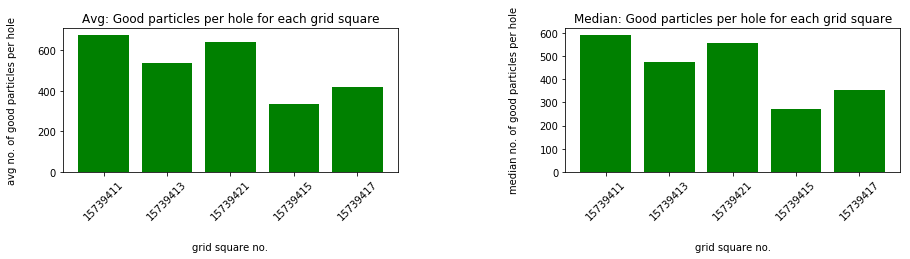

In [18]:
# plot number of good particles per hole vs grid square no.

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))

plt.subplot(221)

plt.bar(output_data["grid square name"],output_data["avg no. of particles per micrograph"], color = "green", label = "data1")
plt.title('Avg: Good particles per hole for each grid square')
plt.xlabel('grid square no.', labelpad = 20)
plt.ylabel('avg no. of good particles per hole', labelpad = 20)
plt.xticks(rotation=45)


plt.subplot(222)

plt.bar(output_data["grid square name"],output_data["median no. of particles per micrograph"], color = "green", label = "data1")
plt.title('Median: Good particles per hole for each grid square')
plt.xlabel('grid square no.', labelpad = 20)
plt.ylabel('median no. of good particles per hole', labelpad = 20)
plt.xticks(rotation=45)


plt.subplots_adjust(bottom=0.25, top=0.75, wspace = 0.5, hspace = 0.5)
plt.show()

# 9
Plot number of particles vs micrograph

# Plotting outline

plot histogram of each coordinate - just to see distribution
then plot histogram on xy plane

In [ ]:
# histograms

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


num_bins = 50

plt.figure(figsize=(15,15))

#ax = plt.subplot(121)
#ax.set_aspect(1)



plt.subplot(221)

plt.hist(coordinates["x_coordinate"], num_bins, density=1)
plt.title('Histogram of x_coordinate distribution')
plt.xlabel('x_coordinate')
plt.ylabel('Probability density')
plt.xticks(ax.get_xticks()[::2])
plt.xticks(rotation=45)



plt.subplot(222)

plt.hist(coordinates["y_coordinate"], num_bins, density=1)
plt.title('Histogram of y_coordinate distribution')
plt.xlabel('y_coordinate')
plt.ylabel('Probability density')
plt.xticks(ax.get_xticks()[::2])
plt.xticks(rotation=45)



# plt.subplot(223)

# plt.hist(coordinates["x_origin"], num_bins, density=1)
# plt.title('Histogram of x_origin distribution')
# plt.xlabel('x_origin')
# plt.ylabel('Probability density')
# plt.xticks(ax.get_xticks()[::2])
# plt.xticks(rotation=45)



# plt.subplot(224)

# plt.hist(coordinates["y_origin"], num_bins, density=1)
# plt.title('Histogram of y_origin distribution')
# plt.xlabel('y_origin')
# plt.ylabel('Probability density')
# plt.xticks(ax.get_xticks()[::2])
# plt.xticks(rotation=45)



plt.subplots_adjust(bottom=0.25, top=0.75, wspace = 0.5, hspace = 0.5)
#plt.subplots_adjust(wspace = 0.5, hspace = 2)
#fig.tight_layout()
plt.show()

In [ ]:
# inspect the range of values in the coordinates dataframe

coord_summary = pd.DataFrame(columns = ['parameter', 'min', 'max'])

x_coord_min = coordinates['x_coordinate'].min()
x_coord_max = coordinates['x_coordinate'].max()
coord_summary = coord_summary.append({'parameter': 'x_coordinate', 'min': x_coord_min, 'max': x_coord_max}, ignore_index=True)

y_coord_min = coordinates['y_coordinate'].min()
y_coord_max = coordinates['y_coordinate'].max()
coord_summary = coord_summary.append({'parameter': 'y_coordinate', 'min': y_coord_min, 'max': y_coord_max}, ignore_index=True)

# x_ori_min = coordinates['x_origin'].min()
# x_ori_max = coordinates['x_origin'].max()
# coord_summary = coord_summary.append({'parameter': 'x_origin', 'min': x_ori_min, 'max': x_ori_max}, ignore_index=True)

# y_ori_min = coordinates['y_origin'].min()
# y_ori_max = coordinates['y_origin'].max()
# coord_summary = coord_summary.append({'parameter': 'y_origin', 'min': y_ori_min, 'max': y_ori_max}, ignore_index=True)

coord_summary

In [ ]:
x_coord_string = coordinates['x_coordinate'].tolist()
x_coord_float = [float(i) for i in x_coord_string]
#print(len(x))
#print(x[0:50], '\n')

y_coord_string = coordinates['y_coordinate'].tolist()
y_coord_float = [float(i) for i in y_coord_string]
#print(len(y))
#print(y[0:50], '\n')


# 3D histogram
# https://matplotlib.org/gallery/mplot3d/hist3d.html


# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#hist, xedges, yedges = np.histogram2d(x, y, bins=100, range=[[x_coord_min, x_coord_max], [y_coord_min, y_coord_max]])
hist, xedges, yedges = np.histogram2d(x_coord_float, y_coord_float, bins=50, range=[[0, 4000], [0, 4000]], normed = True)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the bars.
dx = 10 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

plt.show()

In [ ]:
x_coord_string = coordinates['x_coordinate'].tolist()
x_coord_float = [float(i) for i in x_coord_string]
#print(len(x))
#print(x[0:50], '\n')

y_coord_string = coordinates['y_coordinate'].tolist()
y_coord_float = [float(i) for i in y_coord_string]
#print(len(y))
#print(y[0:50], '\n')

# histogram heatmap
# https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

import numpy as np
import numpy.random
import matplotlib.pyplot as plt

heatmap, xedges, yedges = np.histogram2d(x_coord_float, y_coord_float, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()

plt.show()

x_ori_string = coordinates['x_origin'].tolist()
x_ori_float = [float(i) for i in x_ori_string]
#print(len(x))
#print(x[0:50], '\n')

y_ori_string = coordinates['y_origin'].tolist()
y_ori_float = [float(i) for i in y_ori_string]
#print(len(y))
#print(y[0:50], '\n')


# histogram heatmap
# https://stackoverflow.com/questions/2369492/generate-a-heatmap-in-matplotlib-using-a-scatter-data-set

import numpy as np
import numpy.random
import matplotlib.pyplot as plt

heatmap, xedges, yedges = np.histogram2d(x_ori_float, y_ori_float, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()

plt.show()

## 10
Make histograms for x and y coordiantes & origins - but do this separately for each grid square

In [ ]:
# separate particles from different grid squares into separate pandas dataframes
# plot x & y coordinates for each grid square
# plot x & y origins for each grid square

In [ ]:
test = particles[particles['grid_square_no'] == str(15739417)]
test.tail()

In [ ]:
# extract particles for each grid square from the particles dataframe

# create a list to store the sub-dataframes
grid_particles = []

# populate the list
for i in grid_squares:
    # create a name for the sub-dataframe
    i = str(i)
    subframe = particles[particles['grid_square_no'] == i]
    grid_particles.append(subframe)

# see what happened
print(grid_particles[2].head())
type(grid_particles[0])

In [ ]:
# create a list to store the sub-dataframes
grid_coordinates = []

# populate the list
for i in grid_squares:
    # create a name for the sub-dataframe
    i = str(i)
    subframe = coordinates[coordinates['grid_square_no'] == i]
    grid_coordinates.append(subframe)

# see what happened
print(grid_coordinates[2].head())
type(grid_coordinates[0])

# 3D histogram
# https://matplotlib.org/gallery/mplot3d/hist3d.html


# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


#hist, xedges, yedges = np.histogram2d(x, y, bins=100, range=[[x_coord_min, x_coord_max], [y_coord_min, y_coord_max]])
hist, xedges, yedges = np.histogram2d(x, y, bins=25, range=[[0, 1000], [0, 1000]], normed = True)

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

# Construct arrays with the dimensions for the bars.
dx = 0.5 * np.ones_like(zpos)
dy = dx.copy()
dz = hist.flatten()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')

plt.show()

# doesn't work nicely
# needs figuring out

# histograms

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

num_bins = 50

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# histogram for the x_coordinate
axs[0, 0].hist(coordinates["x_coordinate"], num_bins, density=1)
axs[0, 0].set_title('Histogram of x_coordinate distribution', fontsize=15)
axs[0, 0].set_xlabel('x_coordinate', fontsize=15, labelpad = 10)
axs[0, 0].set_ylabel('Probability density', fontsize=15, labelpad = 10)
axs[0, 0].set_xticks(ax.get_xticks()[::500])
plt.xticks(rotation=45)

# histogram for the y_coordinate
axs[1, 0].hist(coordinates["y_coordinate"], num_bins, density=1)
axs[1, 0].set_title('Histogram of y_coordinate distribution', fontsize=15)
axs[1, 0].set_xlabel('y_coordinate', fontsize=15, labelpad = 10)
axs[1, 0].set_ylabel('Probability density', fontsize=15, labelpad = 10)
axs[1, 0].set_xticks(ax.get_xticks()[::10])
plt.xticks(rotation=45)

# histogram for the x_origin
axs[0, 1].hist(coordinates["x_origin"], num_bins, density=1)
axs[0, 1].set_title('Histogram of x_origin distribution', fontsize=15)
axs[0, 1].set_xlabel('x_origin', fontsize=15, labelpad = 10)
axs[0, 1].set_ylabel('Probability density', fontsize=15, labelpad = 10)
axs[0, 1].set_xticks(ax.get_xticks()[::10])
plt.xticks(rotation=45)

# histogram for the y_origin
axs[1, 1].hist(coordinates["y_origin"], num_bins, density=1)
axs[1, 1].set_title('Histogram of y_origin distribution', fontsize=15)
axs[1, 1].set_xlabel('y_origin', fontsize=15, labelpad = 10)
axs[1, 1].set_ylabel('Probability density', fontsize=15, labelpad = 10)
axs[1, 1].set_xticks(ax.get_xticks()[::10])
plt.xticks(rotation=45)

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()